## **pyTopoComplexity**
### **DEM pre-processing notebook for pyTopoComplexity**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GeoLarryLai/pyTopoComplexity/blob/main/DEM_preprocessing.ipynb)

The DEM data may sometimes contain empty or invalid data holes due to incomplete data collection or coordinate reprojection. Issues such as grid imperfections after coordinate system reprojection or unit inconsistencies (e.g., mismatched units in XYZ, or values not in meters or feet) can arise and cause errors when executing pyTopoComplexity modules. 

To address these potential problems, I developed this notebook for pre-processing DEM raster data (when needed) before running pyTopoComplexity. The notebook includes functions for:
- Reading and visualizing DEM data with hillshade effects
- Handling coordinate reference systems and unit conversions
- Filling empty or invalid grid cells through data interpolation
- Cropping artifacts introduced by pyTopoComplexity modules after analysis”

The example GeoTIFF rasters include lidar Digital Elevation Model (DEM) files that cover areas with varying topographic complexity, allowing demonstration of different preprocessing and analysis techniques.

Archives of codes and example DEM data:
* Zenodo: https://doi.org/10.5281/zenodo.11239338
* Github repository: https://github.com/GeoLarryLai/pyTopoComplexity
<hr>

#### **0. Import packages**
##### Check installation of pyTopoComplexity

In [1]:
!pip install pytopocomplexity

##### Import packages

In [2]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling
import numpy as np
from scipy.interpolate import griddata
import os
import matplotlib.pyplot as plt

from pytopocomplexity import CWTMexHat  # import the CWTMexHat module for this example

##### Functions for DEM pre-processing

In [3]:
def plot_raster(raster_path, title, cmap='terrain', hillshade=True):
    """
    Reads and plots a raster file with optional hillshade visualization and metadata display.

    This function reads a raster file and creates a visualization with optional hillshade
    effect for DEMs. It automatically handles nodata values, displays coordinate system
    information, and prints comprehensive metadata after plotting.

    Parameters:
    -----------
    raster_path : str
        Path to the raster file to be plotted.
    title : strå
        The title to display on the plot.
    cmap : str, optional
        The colormap to use for visualization. Default is 'terrain'.
    hillshade : bool, optional
        Whether to compute and display a hillshade effect. Default is True.

    Returns:
    --------
    None
        Displays the plot and prints metadata to console.

    Notes:
    ------
    For DEMs with hillshade=True, the function computes a simple hillshade using
    gradient calculations with azimuth=315° and altitude=45°. The hillshade is
    displayed as a grayscale base layer with the DEM overlaid with transparency.
    """
    if not os.path.exists(raster_path):
        print(f"Plotting skipped: File not found at {raster_path}")
        return
        
    try:
        with rasterio.open(raster_path) as src:
            data = src.read(1)
            # Replace nodata values with NaN for plotting
            if src.nodata is not None:
                data[data == src.nodata] = np.nan
            # Print Coordinate System
            if src.crs:
                try:
                    # Attempt to get the EPSG code and name for a cleaner output
                    epsg_code = src.crs.to_epsg()
                    crs_name = src.crs.name
                    print(f"Coordinate System: EPSG:{epsg_code} - {crs_name}")
                except (AttributeError, TypeError):
                    # Fallback for CRS without a standard EPSG code
                    print(f"Coordinate System: {src.crs.to_string()}")

                # Print Units
                if src.crs.is_projected:
                    xy_units = src.crs.linear_units
                    # Assume Z units are the same as XY units for projected systems
                    z_units = xy_units
                    print(f"  - X/Y Units: {xy_units}")
                    print(f"  - Z Units (assumed): {z_units}")
                elif src.crs.is_geographic:
                    xy_units = src.crs.angular_units
                    # Z units for geographic CRS are typically meters, but can vary.
                    # This is a reasonable assumption for most DEMs.
                    z_units = "meter" 
                    print(f"  - X/Y Units: {xy_units}")
                    print(f"  - Z Units (assumed): {z_units}")
            else:
                print("Coordinate System: Not defined.")
                print("  - Units: Unknown")

            # Plot the raster
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            
            if hillshade:
                # Simple hillshade calculation from elevation data
                dx, dy = np.gradient(data, 1, 1)
                slope = np.pi/2. - np.arctan(np.sqrt(dx*dx + dy*dy))
                aspect = np.arctan2(-dx, dy)
                azimuth = 315. * np.pi/180.  # from the northwest
                altitude = 45. * np.pi/180.  # 45 degrees
                
                x = np.sin(altitude) * np.sin(slope)
                y = np.cos(altitude) * np.cos(slope) * np.cos(azimuth - aspect)
                hillshade = 255 * (x + y)
                
                # Display hillshade as the base layer
                ax.imshow(hillshade, cmap='gray', vmin=0, vmax=255)
                # Overlay the DEM with transparency
                im = ax.imshow(data, cmap=cmap, alpha=0.5)
                fig.colorbar(im, ax=ax, label=f'Elevation ({z_units})')
            else:
                # Display non-DEM data like slope directly
                im = ax.imshow(data, cmap=cmap)
                fig.colorbar(im, ax=ax, label='Value')

            ax.set_title(title)
            ax.set_xlabel(f'X-coordinate (pixels). Unit: {xy_units}')
            ax.set_ylabel(f'Y-coordinate (pixels). Unit: {xy_units}')
            plt.tight_layout()
            plt.show() # Show the plot first

            # --- Print metadata after showing the figure ---
            print("\n--- Raster Metadata ---")
            print(f"File: {os.path.basename(raster_path)}")

    except Exception as e:
        print(f"An error occurred during plotting: {e}")

def reproject_to_utm(input_raster_path, output_raster_path, target_utm_epsg, show_fig=False):
    """
    Reprojects a raster to UTM coordinate system and converts elevation units to meters.

    This function checks if a raster's CRS matches the target UTM projection and
    reprojects if necessary. It also handles vertical unit conversion from feet
    to meters, distinguishing between US survey feet and international feet.

    Parameters:
    -----------
    input_raster_path : str
        Path to the input GeoTIFF file to be reprojected.
    output_raster_path : str
        Path where the reprojected GeoTIFF file will be saved.
    target_utm_epsg : str
        The EPSG code for the target UTM coordinate system (e.g., 'EPSG:32610').
    show_fig : bool, optional
        Whether to display a plot of the output raster. Default is False.

    Returns:
    --------
    None
        Saves the reprojected raster to the specified output path.

    Notes:
    ------
    The function applies different conversion factors based on foot type:
    - US survey feet: 1200/3937 ≈ 0.304800609601 meters
    - International feet: 0.3048 meters exactly
    
    Uses nearest neighbor resampling to preserve original elevation values.
    """
    with rasterio.open(input_raster_path) as src:
        # 1. Determine conversion factor for vertical units (e.g., feet to meters)
        conversion_factor = 1.0
        ft2m_us = 1200 / 3937  # US survey foot to meter conversion factor
        ft2m_int = 0.3048      # International foot to meter conversion factor

        if src.crs and src.crs.linear_units:
            units_lower = src.crs.linear_units.lower()
            if any(unit in units_lower for unit in ["foot", "feet", "ft"]):
                # Check for US survey foot, which often contains 'us' or 'survey'
                if any(unit in units_lower for unit in ["us", "survey"]):
                    conversion_factor = ft2m_us
                    print(f"Detected Z units in US survey feet. Applying conversion factor of ~{conversion_factor:.6f}.")
                else:
                    conversion_factor = ft2m_int
                    print(f"Detected Z units in international feet. Applying conversion factor of {conversion_factor}.")

        # 2. Read data and apply Z conversion if necessary
        data = src.read(1)
        if conversion_factor != 1.0:
            nodata_val = src.nodata
            if nodata_val is not None:
                valid_mask = data != nodata_val
                data[valid_mask] = data[valid_mask] * conversion_factor
            else:
                # If no nodata value, convert the whole array
                data = data * conversion_factor
        
        # 3. Check if reprojection of X/Y coordinates is needed
        is_metric = src.crs.is_projected and 'metre' in src.crs.linear_units.lower()
        try:
            current_epsg = src.crs.to_epsg()
        except (AttributeError, TypeError):
            current_epsg = 0

        needs_reprojection = not (str(current_epsg) == target_utm_epsg.split(':')[1] and is_metric)

        # 4. Process based on what needs to be done
        if not needs_reprojection and conversion_factor == 1.0:
            # Case 1: Everything is already correct. Just copy the file.
            print(f"Raster is already in the target UTM projection ({target_utm_epsg}) with metric units.")
            import shutil
            shutil.copy(input_raster_path, output_raster_path)
        
        elif not needs_reprojection and conversion_factor != 1.0:
            # Case 2: Correct projection, but Z units needed conversion. Save the converted data.
            print("CRS is correct, but Z units were converted to meters. Saving new file.")
            profile = src.profile.copy()
            with rasterio.open(output_raster_path, 'w', **profile) as dst:
                dst.write(data, 1)

        else:  # Case 3 & 4: Reprojection is required (with or without Z conversion)
            print(f"Reprojecting raster to {target_utm_epsg}...")
            transform, width, height = calculate_default_transform(src.crs, target_utm_epsg, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({'crs': target_utm_epsg, 'transform': transform, 'width': width, 'height': height})
            
            with rasterio.open(output_raster_path, 'w', **kwargs) as dst:
                reproject(
                    source=data,  # Use the (potentially Z-converted) data array
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_utm_epsg,
                    resampling=Resampling.nearest
                )
            print(f"Reprojection and/or Z-unit conversion complete. Saved to {output_raster_path}")

    if show_fig:
        plot_raster(output_raster_path, title=f'Processed DEM ({target_utm_epsg})')

def fill_nodata_holes(input_raster_path, output_raster_path, method='idw', show_fig=False):
    """
    Fills nodata holes in a raster using spatial interpolation methods.

    This function identifies nodata values in a raster and fills them using
    various interpolation techniques. It handles cases where interpolation
    fails by falling back to nearest neighbor interpolation.

    Parameters:
    -----------
    input_raster_path : str
        Path to the input GeoTIFF file containing nodata holes.
    output_raster_path : str
        Path where the filled GeoTIFF file will be saved.
    method : str, optional
        Interpolation method to use. Options: 'idw', 'spline', 'kriging'. Default is 'idw'.
    show_fig : bool, optional
        Whether to display a plot of the output raster. Default is False.

    Returns:
    --------
    None
        Saves the filled raster to the specified output path.

    Notes:
    ------
    Method mappings:
    - 'idw': Uses nearest neighbor interpolation (simple IDW approximation)
    - 'spline': Uses cubic spline interpolation
    - 'kriging': Falls back to cubic interpolation (kriging not fully implemented)
    
    If interpolation fails for some points, the function automatically applies
    nearest neighbor interpolation as a fallback.
    """
    with rasterio.open(input_raster_path) as src:
        data = src.read(1)
        profile = src.profile
        nodata_val = src.nodata
        if nodata_val is None: valid_mask = np.full(data.shape, True)
        else: valid_mask = data != nodata_val

        if np.all(valid_mask):
            print("No nodata holes found in the raster.")
            import shutil
            shutil.copy(input_raster_path, output_raster_path)
        else:
            print(f"Filling nodata holes using '{method}' interpolation...")
            rows, cols = np.indices(data.shape)
            valid_rows, valid_cols, valid_values = rows[valid_mask], cols[valid_mask], data[valid_mask]
            nodata_rows, nodata_cols = rows[~valid_mask], cols[~valid_mask]
            
            interpolation_method = 'cubic'
            if method.lower() == 'idw': interpolation_method = 'nearest'
            elif method.lower() == 'kriging':
                print("Warning: Kriging is complex. Using 'cubic' as a fallback.")
                interpolation_method = 'cubic'

            filled_values = griddata((valid_rows, valid_cols), valid_values, (nodata_rows, nodata_cols), method=interpolation_method)
            filled_data = data.copy()
            # Handle cases where interpolation might fail for some points
            if np.isnan(filled_values).any():
                print("Warning: Some nodata points could not be interpolated. Filling with nearest.")
                nan_mask = np.isnan(filled_values)
                # Get coordinates of points that failed interpolation
                failed_nodata_rows = nodata_rows[nan_mask]
                failed_nodata_cols = nodata_cols[nan_mask]
                # Fallback to nearest neighbor for those specific points
                fallback_values = griddata((valid_rows, valid_cols), valid_values, (failed_nodata_rows, failed_nodata_cols), method='nearest')
                filled_values[nan_mask] = fallback_values

            filled_data[~valid_mask] = filled_values
            filled_data = filled_data.astype(profile['dtype'])
            with rasterio.open(output_raster_path, 'w', **profile) as dst:
                dst.write(filled_data, 1)
            print(f"Hole filling complete. Saved to {output_raster_path}")

    if show_fig:
        plot_raster(output_raster_path, title=f'DEM with Holes Filled ({method})')


def mask_raster(input_raster_path, mask_raster_path, output_raster_path, show_fig=False):
    """
    Applies a mask to crop or filter areas of an input raster.

    This function uses a mask raster to selectively remove or retain areas
    of an input raster. Areas in the mask raster that contain nodata values
    will be set to nodata in the output raster.

    Parameters:
    -----------
    input_raster_path : str
        Path to the raster file to be masked/cropped.
    mask_raster_path : str
        Path to the raster file to be used as a mask.
    output_raster_path : str
        Path where the masked raster will be saved.
    show_fig : bool, optional
        Whether to display a plot of the output raster. Default is False.

    Returns:
    --------
    None
        Saves the masked raster to the specified output path.

    Notes:
    ------
    Both input and mask rasters must have identical dimensions (height, width).
    The function preserves the input raster's profile and only modifies pixel
    values where the mask contains nodata values.
    """
    with rasterio.open(mask_raster_path) as mask_src:
        mask_data = mask_src.read(1)
        nodata_val = mask_src.nodata
    with rasterio.open(input_raster_path) as input_src:
        if input_src.shape != mask_src.shape:
            raise ValueError("Input raster and mask raster must have the same dimensions.")
        input_data = input_src.read(1)
        profile = input_src.profile
        print("Applying mask to the raster...")
        output_data = input_data.copy()
        if nodata_val is not None:
             output_data[mask_data == nodata_val] = profile['nodata']
        else:
            print("Warning: Mask raster has no nodata value defined.")
        with rasterio.open(output_raster_path, 'w', **profile) as dst:
            dst.write(output_data, 1)
        print(f"Masking complete. Saved to {output_raster_path}")

    if show_fig:
        # The masked raster is not a DEM, so set hillshade=False
        plot_raster(output_raster_path, title='Final Masked Result', cmap='viridis', hillshade=False)


def create_synthetic_dem_with_hole(output_path):
    """
    Creates a synthetic DEM raster with an artificial data hole for testing purposes.

    This function generates a simple synthetic elevation model with a rectangular
    nodata hole in the center, useful for testing hole-filling algorithms.

    Parameters:
    -----------
    output_path : str
        Path where the synthetic DEM will be saved.

    Returns:
    --------
    None
        Saves the synthetic DEM to the specified output path.

    Notes:
    ------
    The generated DEM is a 100x100 pixel raster in geographic coordinates
    (EPSG:4326) with a 20x20 pixel nodata hole in the center. Elevation
    values are simple sequential integers from 0 to 9999.
    """
    transform = rasterio.transform.from_origin(-122.5, 37.8, 0.001, 0.001)
    profile = {'driver': 'GTiff', 'crs': 'EPSG:4326', 'transform': transform, 'width': 100, 'height': 100, 'count': 1, 'dtype': rasterio.float32, 'nodata': -9999.0}
    data = np.arange(10000, dtype=np.float32).reshape(100, 100)
    data[40:60, 40:60] = -9999.0
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)
    print(f"Created a sample DEM with a data hole: {output_path}")


##### Define the directory of the input example DEM raster

Available LiDAR DEM files:
* **Ososlid2014_f_3ftgrid.tif**
    * CRS: NAD83/Washington South (ftUS) (EPSG: 2286)
    * XY Grid Size: 3.0 [US survey feet]
    * Z Unit: US survey feet
* **Ososlid2014_m_3ftgrid.tif**
    * CRS: NAD83/Washington South (EPSG: 32149)
    * XY Grid Size: ~0.9144 [meters]
    * Z Unit: meters
* **Ososlid2014_f_6ftgrid.tif**
    * CRS: NAD83/Washington South (ftUS) (EPSG: 2286)
    * XY Grid Size: 6.0 [US survey feet]
    * Z Unit: US survey feet
* **Ososlid2014_m_6ftgrid.tif**
    * CRS: NAD83/Washington South (EPSG: 32149)
    * XY Grid Size: ~1.8288 [meters]
    * Z Unit: meters

If the directory doesn't exist, the code will download the example DEM file from the pyTopoComplexity Github repository. 

In [4]:
# Define input file name and directory
base_dir = os.path.join(os.getcwd(), 'ExampleDEM')  # input file base directory
input_file = 'Ososlid2014_f_6ftgrid.tif'           # input file name
original_dem_path = os.path.join(base_dir, input_file)     # input file directory

# Check if base file directory exists. If not, create it
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Define the download URL if the example file does not exist in the base_dir
download_url = "https://github.com/GeoLarryLai/pyTopoComplexity/raw/main/ExampleDEM/" + input_file

# Check if file exists, if not, download it
if not os.path.exists(original_dem_path):
    try:
        import requests
        response = requests.get(download_url)
        response.raise_for_status()  # Raise an exception for 4XX/5XX responses
        with open(original_dem_path, 'wb') as f:
            f.write(response.content)
        print(f"Example DEM file {input_file} downloaded to {base_dir}")
    except requests.exceptions.RequestException as e:
        print(f"The file {input_file} does not exist locally or on the GitHub repository.\n{e}")
        raise SystemExit(1)
else:
    print(f"Example DEM file {input_file} already exist in the {base_dir}")

base_name = os.path.splitext(input_file)[0]
reprojected_dem_path = os.path.join(base_dir, f'{base_name}_reprojected2utm.tif')
filled_dem_path = os.path.join(base_dir, f'{base_name}_holefilled.tif')
cwt_map_path = os.path.join(base_dir, f'{base_name}_cwt.tif')
final_slope_path = os.path.join(base_dir, f'{base_name}_masked_cwt.tif')

Example DEM file Ososlid2014_f_6ftgrid.tif already exist in the /Users/larryslai/Library/CloudStorage/Dropbox/My Documents/Paper manuscripts/2025-pyTopoComplexity/pyTopoComplexity/ExampleDEM


<hr>

#### **1. Show Original DEM**
The `plot_raster` function will visualize the DEM raster with optional hillshade overlay.
 
**Parameters:**
* `raster_path`: file directory to the input DEM raster.
* `title` *[optional]*: title for the plot display.
* `cmap` *[optional]*: colormap for the plot display.
* `hillshade` *[optional]*: whether to apply hillshade overlay, either True or False (default).

**Outputs:**
* Displays a matplotlib figure showing the DEM visualization with optional hillshade effect.

Coordinate System: PROJCS["NAD83(HARN) / Washington South (ftUS)",GEOGCS["NAD83(HARN)",DATUM["North_American_1983_HARN",SPHEROID["GRS 1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",45.3333333333333],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",45.8333333333333],PARAMETER["standard_parallel_2",47.3333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  - X/Y Units: US survey foot
  - Z Units (assumed): US survey foot


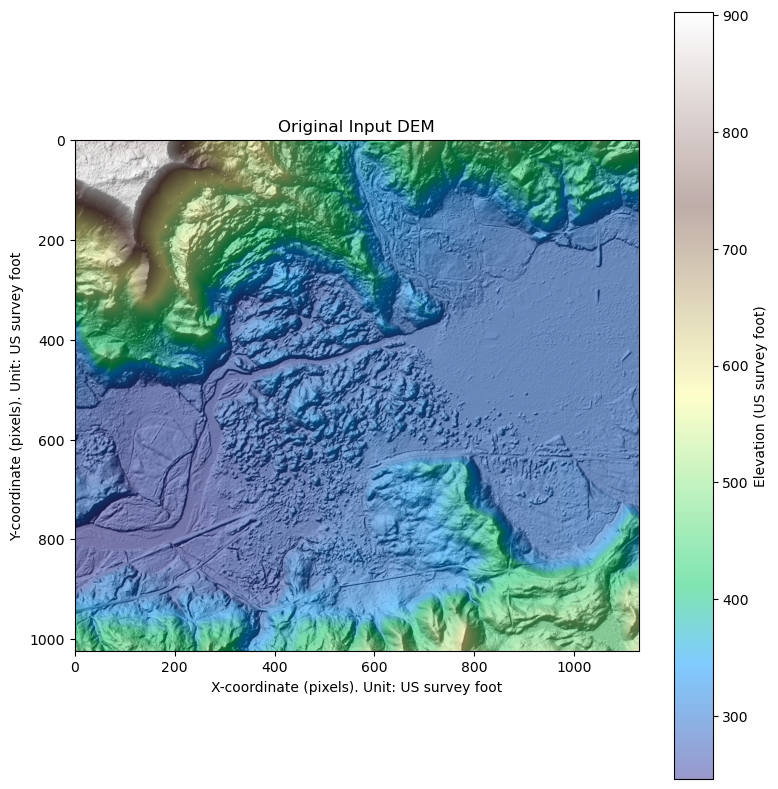


--- Raster Metadata ---
File: Ososlid2014_f_6ftgrid.tif


In [5]:
plot_raster(
    raster_path=original_dem_path, 
    title='Original Input DEM', 
    cmap='terrain', 
    hillshade=True
)

#### **2. Reproject to UTM**
The `reproject_to_utm` function reprojects the DEM to UTM coordinate system and ensures elevation values are in meters.

**Parameters:**
* `input_raster_path`: file directory to the original DEM raster.
* `output_raster_path`: output file directory for the reprojected DEM.
* `target_epsg`: target UTM EPSG code for reprojection.
* `show_fig` *[optional]*: whether to display visualization, either True or False (default).

**Outputs:**
* Creates a reprojected DEM file in UTM coordinates with elevation in meters.
* Optionally displays a matplotlib figure showing the reprojected DEM.

Detected Z units in US survey feet. Applying conversion factor of ~0.304801.
Reprojecting raster to EPSG:32610...
Reprojection and/or Z-unit conversion complete. Saved to /Users/larryslai/Library/CloudStorage/Dropbox/My Documents/Paper manuscripts/2025-pyTopoComplexity/pyTopoComplexity/ExampleDEM/Ososlid2014_f_6ftgrid_reprojected2utm.tif
Coordinate System: EPSG:32610
  - X/Y Units: metre
  - Z Units (assumed): metre


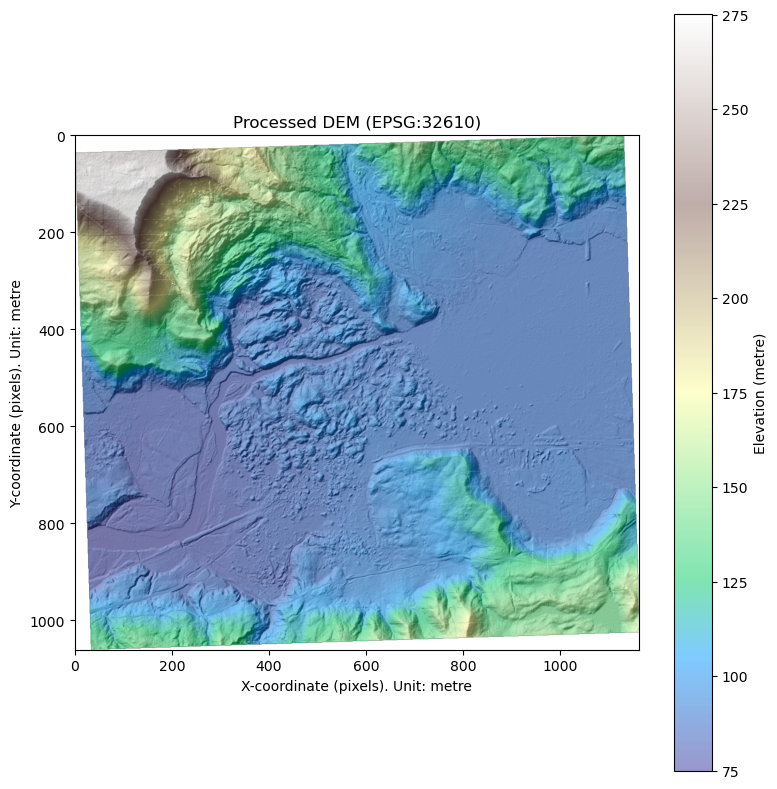


--- Raster Metadata ---
File: Ososlid2014_f_6ftgrid_reprojected2utm.tif


In [6]:
reproject_to_utm(
    input_raster_path=original_dem_path, 
    output_raster_path=reprojected_dem_path, 
    target_utm_epsg='EPSG:32610',  #assign a UTM EPSG code for WGS 84 / UTM zone 10N as an example
    show_fig=True
)

#### **3. Fill Data Holes**
The `fill_nodata_holes` function fills missing data (NoData values) in the DEM using interpolation methods.

**Parameters:**
* `input_raster_path`: file directory to the input DEM raster (it could be the reprojected DEM as shown in the example here, or it could be the original DEM if no reprojection is needed).
* `output_raster_path`: output file directory for the hole-filled DEM.
* `method` *[optional]*: interpolation method - 'idw' (default), 'spline', or 'kriging'.
* `show_fig` *[optional]*: whether to display visualization, either True or False (default).

**Outputs:**
* Creates a DEM file with filled NoData holes using the specified interpolation method.
* Optionally displays a matplotlib figure showing the filled DEM.


Filling nodata holes using 'idw' interpolation...
Hole filling complete. Saved to /Users/larryslai/Library/CloudStorage/Dropbox/My Documents/Paper manuscripts/2025-pyTopoComplexity/pyTopoComplexity/ExampleDEM/Ososlid2014_f_6ftgrid_holefilled.tif
Coordinate System: EPSG:32610
  - X/Y Units: metre
  - Z Units (assumed): metre


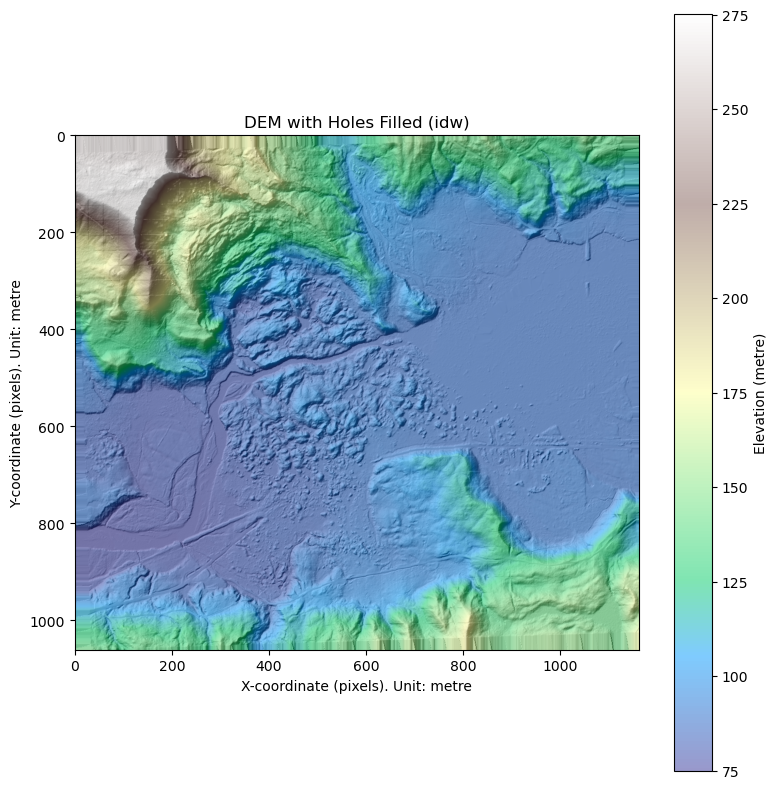


--- Raster Metadata ---
File: Ososlid2014_f_6ftgrid_holefilled.tif


In [7]:
fill_nodata_holes(
    input_raster_path=reprojected_dem_path, 
    output_raster_path=filled_dem_path, 
    method='idw', 
    show_fig=True
)

#### **4. Apply CWT Analysis**
The `CWTMexHat` class performs Continuous Wavelet Transform analysis using Mexican Hat wavelet to detect topographic features.

**Parameters for CWTMexHat initialization:**
* `Lambda`: wavelet scale parameter for feature detection.

**Parameters for analyze() function:**
* `filled_dem_path`: file directory to the hole-filled DEM raster.
* `conv_method` *[optional]*: convolution method - 'fft' (default) or 'direct'.
* `chunk_processing` *[optional]*: whether to use chunked processing for large datasets, either True (default) or False.
* `chunksize` *[optional]*: size of processing chunks as tuple (height, width).

**Parameters for export_result() function:**
* `cwt_map_path`: output file directory for the CWT analysis result.

**Parameters for plot_result() function:**
* `output_dir` *[optional]*: directory to save the plot figure.
* `savefig` *[optional]*: whether to save the figure, either True or False (default).
* `figshow` *[optional]*: whether to display the figure, either True (default) or False.
* `showhillshade` *[optional]*: whether to overlay hillshade, either True (default) or False.
* `cwtcolormax` *[optional]*: maximum value for CWT color scale.

**Outputs:**
* `analyze()`: Performs CWT analysis and returns analysis results.
* `export_result()`: Creates a CWT analysis result file showing detected topographic features.
* `plot_result()`: Displays a matplotlib figure showing the CWT result with optional hillshade overlay.


[########################################] | 100% Completed | 104.57 ms
'Ososlid2014_f_6ftgrid_cwt.tif' is saved


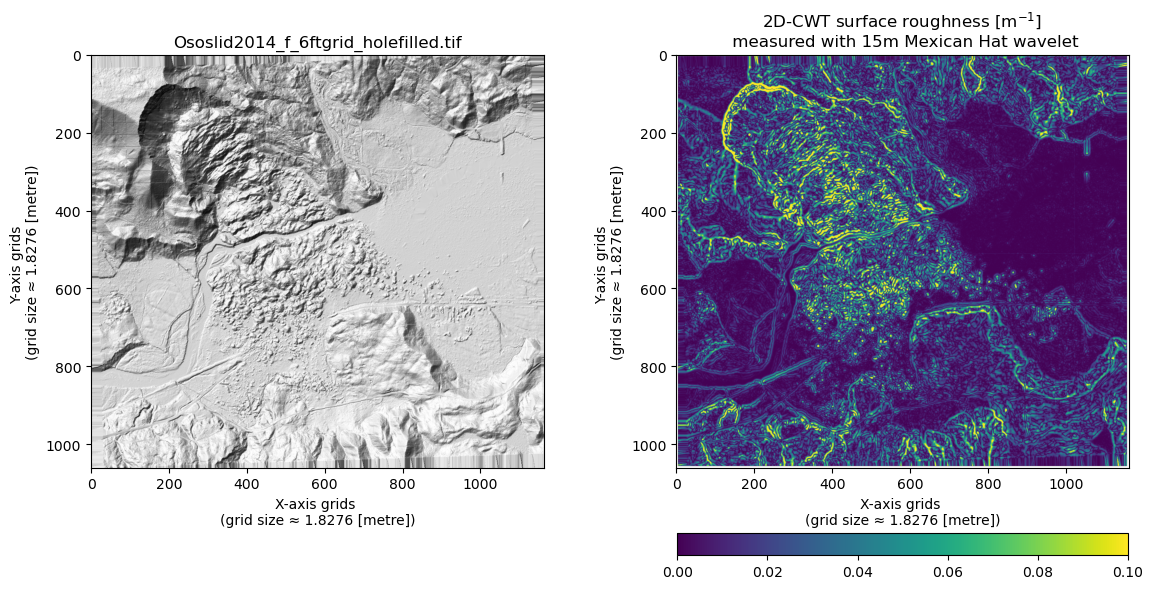

In [8]:
cwt = CWTMexHat(Lambda=15)

_, _ = cwt.analyze(
    filled_dem_path, 
    conv_method='fft', 
    chunk_processing=True, 
    chunksize=(512,512)
    )

cwt.export_result(cwt_map_path)

cwt.plot_result(
    output_dir=None,
    savefig=False, 
    figshow=True, 
    showhillshade=True,
    cwtcolormax=None
    )

#### **5. Mask out the pyTopoComplexity outputs in the nodata regions of the original DEM data**
The `mask_raster` function will apply a mask to the slope map using the original DEM extent.

**Parameters:**
* `input_raster_path`: file directory to pyTopoComplexity analysis result raster.
* `mask_raster_path`: file directory to the reprojected DEM raster used as mask reference.
* `output_raster_path`: output file directory for the final masked CWT map.
* `show_fig` *[optional]*: whether to display the result figure, either True or False (default).

**Outputs:**
* Creates a final masked slope map file and optionally displays a matplotlib figure showing the result.


Applying mask to the raster...
Masking complete. Saved to /Users/larryslai/Library/CloudStorage/Dropbox/My Documents/Paper manuscripts/2025-pyTopoComplexity/pyTopoComplexity/ExampleDEM/Ososlid2014_f_6ftgrid_masked_cwt.tif
Coordinate System: EPSG:32610
  - X/Y Units: metre
  - Z Units (assumed): metre


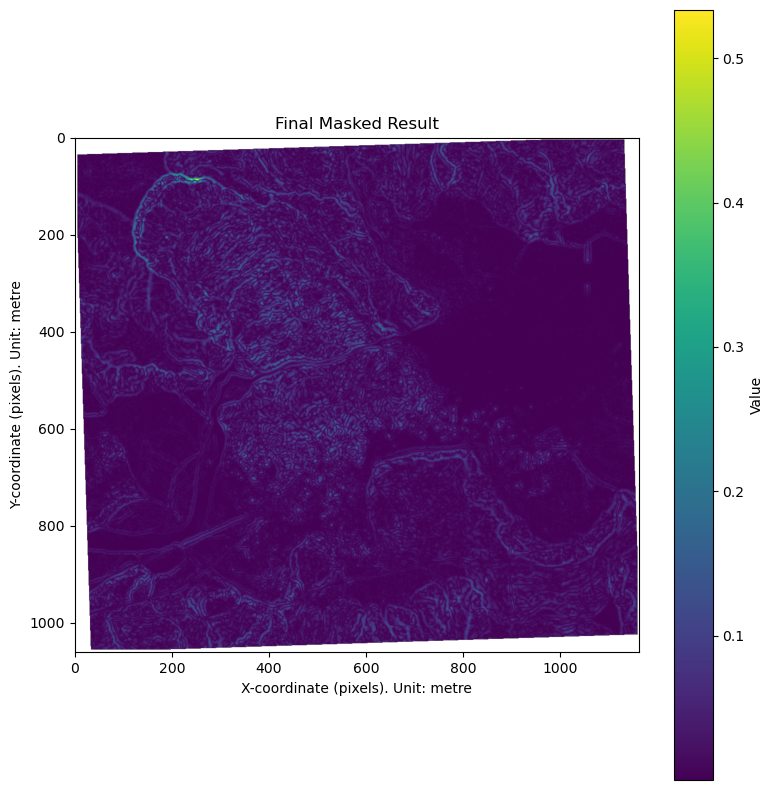


--- Raster Metadata ---
File: Ososlid2014_f_6ftgrid_masked_cwt.tif


In [11]:
# --- Step 5: Mask the Slope Map ---
mask_raster(
    input_raster_path=cwt_map_path, 
    mask_raster_path=reprojected_dem_path, 
    output_raster_path=final_slope_path, 
    show_fig=True
)